In [131]:
#libraries
import numpy as np
from scipy.integrate import solve_ivp
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

In [150]:
#general constants
g = 9.81
rocketDragCoef = 0.75
crossSectArea= 0.04

#air resistance constants

rho_0 = 1.225
L = 0.0065  # temperature lapse rate (K/m)
T0 = 288.15  # sea level standard temperature (K)
MolarMass = 0.0289644  # molar mass of Earth's air (kg/mol)
R = 8.3144598  # universal gas constant (J/(mol·K))
C_d = 0.75  # drag coefficient


In [133]:
#air density data
rawAirDensity = np.loadtxt(r"rocketData\air_density.csv", delimiter=',')  # Adjust skiprows based on your file's structure
airDensePoints = rawAirDensity.transpose()
airDenseFunc = interpolate.CubicSpline(airDensePoints[0], airDensePoints[1])

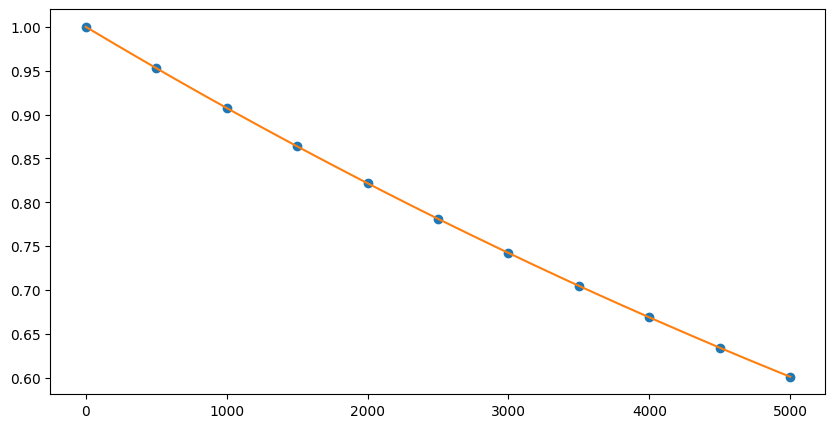

In [154]:
height =  np.linspace(0, 5000,5000)
sampleAirDensity = airDenseFunc(height)

plt.figure(figsize=(10,5))
plt.plot(airDensePoints[0], airDensePoints[1], 'o', label='Data Points')
plt.plot(height,sampleAirDensity)
plt.show()

In [135]:
#thrust data 
rawThrust = np.loadtxt(r'rocketData\thrust_curve.csv', delimiter=',')  # Adjust skiprows based on your file's structure
thrustPoints = rawThrust.transpose()
thrustFunc = interpolate.Akima1DInterpolator(thrustPoints[0], thrustPoints[1])

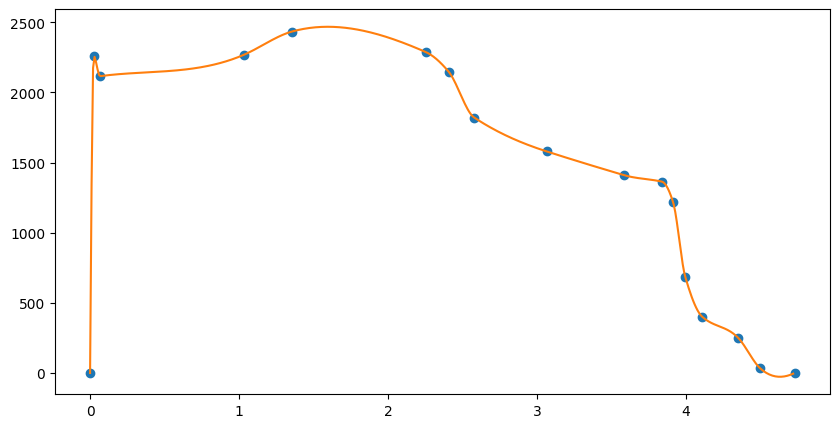

In [152]:
time =  np.linspace(0, 5, 500)
sampleThrust = thrustFunc(time)

plt.figure(figsize=(10,5))
plt.plot(thrustPoints[0], thrustPoints[1], 'o', label='Data Points')
plt.plot(time,sampleThrust)
plt.show()

In [137]:
#thrust curve 
def thrust(t):
    if t <= 4.729  and t >= 0:
        return thrustFunc(t)
    else:
        return 0 

In [138]:
#air density as a function of altitude 
def air_density(h):
    return airDenseFunc(h)


In [162]:
def mass(t):
    mInitial = 50
    burnRate = 3.717/4.5
    if t >= 0 and t <= 4.5:
        return mInitial - burnRate
    else:
        return mInitial - 3.717


In [155]:
#rocket drag given by velocity and height
def rocket_drag(v,h):
    rho = air_density(h)
    return 0.5 * rho * v**2 * rocketDragCoef * crossSectArea
    

In [156]:
def air_brake_drag(v,h,theta):
    airBrakeCoeff = 1.5
    rho = air_density(h)
    if 0 <= theta <= 1:
        return 0.5 * rho * v**2 * airBrakeCoeff * (0.01 * theta)
    else:
        return 0
    


In [142]:
def dynamic_equations(t,y,theta):
    h, v = y
    m = mass(t)
    T = thrust(t)
    D = rocket_drag(v, h)
    Dab= air_brake_drag(v,h,theta)
    dvdt = (T-D-Dab-m*g)/m
    dhdt = v

    return [dhdt, dvdt]




# PID control system

In [143]:
#simulation parameters
desired_apogee = 3000
Kp = 1.0
Ki =  0.1
Kd = 0.05

integral = 0
prevError = 0
deployment = 0

In [144]:
# PID control function
def pid_controller(setpoint, actual, prevError, integral, dt):
    error = setpoint - actual
    integral = error * dt
    derivative = (error - prevError)/dt
    output =  Kp * error + Ki * integral + Kd * derivative
    return output, error, integral

In [145]:
# Initial conditions
y0 = [0, 0]  # initial altitude and velocity
t_span = (0, 20)  # time span for the simulation

In [146]:
t_span[1]

20

In [147]:
# Time points for output
tPoints = np.linspace(t_span[0], t_span[1], 400)

# Running the simulation 

In [148]:
tPoints[1]

0.05012531328320802

In [171]:
# run the simulation with the PID control system
results =[]
for i in range(len(tPoints)):
    currentTime = tPoints[i]
    if i == 0:
        currentState = y0
        dt = tPoints[1]-tPoints[0]
    else:
        dt = tPoints[i] - tPoints[i-1]
    
    deployment, prevError, integral = pid_controller(desired_apogee,currentState[0], prevError, integral, dt)
    deployment = max(0,min(deployment, 1))
    

    solution = solve_ivp(dynamic_equations, [currentTime, currentTime + dt], currentState, args= (deployment,), t_eval= [currentTime + dt])
    currentState = solution.y[:, -1]
    results.append(currentState)


In [170]:
solution.y[:,-1]

array([-0.01232407, -0.49173129])

In [172]:
# Extract results for plotting
h = [state[0] for state in results]
v = [state[1] for state in results]

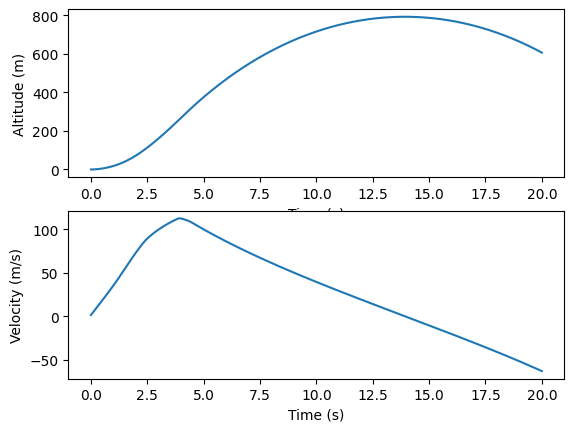

In [173]:
# Plotting results
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(tPoints, h)
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.subplot(2, 1, 2)
plt.plot(tPoints, v)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()